In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import wbdata
import matplotlib.pyplot as plt
import scipy.stats as st
from sympy import *
import time as dt
import warnings
from IPython.display import Math,Latex
from pandas.errors import SettingWithCopyWarning

from sklearn.linear_model import LinearRegression
from statsmodels.api import *
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler

from scipy.stats import jarque_bera, kstest, kstwobign

from country_dict import *
from matplobblib.econometrics import *

In [49]:
df = pd.read_excel('21 ноября.xlsx')
Y = df[['Y']]
df = df[['X1','X2','X3']]
df = add_constant(df)
model = OLS(Y,df).fit()
model.summary()

c:\Users\ivant\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     9.294
Date:                Thu, 21 Nov 2024   Prob (F-statistic):            0.00123
Time:                        15:01:06   Log-Likelihood:                -29.069
No. Observations:                  18   AIC:                             66.14
Df Residuals:                      14   BIC:                             69.70
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.5320     11.088      6.271      0.000      45.750      93.314
X1            -0.0749      0.023     -3.278      0.005      -0.124      -0.026
X2            -0.3492      0.093     -3.740      0.002      -0.550      -0.149
X3            -0.0492      0.022     -2.205      0.045      -0.097      -0.001
==============================================================================
Omnibus:                        0.180   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.914   Jarque-Bera (JB):                0.030
Skew:                          -0.044   Prob(JB):                        0.985
Kurtosis:                       2.819   Cond. No.                     6.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Добавьте константу (не обязательно для VIF, но часто используется в регрессии)
X = df.assign(constant=1)

# Расчёт VIF для каждой переменной
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,feature,VIF
0,X1,1.137075
1,X2,1.147613
2,X3,1.035222
3,constant,1163.073118


In [40]:
from scipy.stats import chi2


# Шаг 1. Общий тест Хи-квадрат
def chi_square_test(corr_matrix, n_obs):
    det = np.linalg.det(corr_matrix)
    if det <= 0:
        raise ValueError("Детерминант корреляционной матрицы отрицателен или равен нулю. Перепроверьте данные.")
    chi2_stat = -(n_obs - 1 - (2 / corr_matrix.shape[0])) * np.log(det)
    df = (corr_matrix.shape[0] * (corr_matrix.shape[0] - 1)) / 2
    p_value = chi2.sf(chi2_stat, df)
    return chi2_stat, p_value

corr_matrix = df.corr()
n_obs = df.shape[0]
chi2_stat, p_value = chi_square_test(corr_matrix, n_obs)
print(f"Хи-квадрат статистика: {chi2_stat:.2f}, p-значение: {p_value:.4f}")

# Интерпретация
if p_value < 0.05:
    print("Обнаружена мультиколлинеарность (значимое отклонение от нуля).")
else:
    print("Мультиколлинеарность не обнаружена.")

# Шаг 2. Индивидуальный тест для каждой переменной
from statsmodels.api import OLS, add_constant

for col in df.columns:
    y = df[col]
    X = df.drop(columns=[col])
    X = add_constant(X)  # Добавляем константу для регрессии
    model = OLS(y, X).fit()
    f_stat = model.fvalue
    f_pval = model.f_pvalue
    print(f"\nТест для переменной {col}: F-статистика = {f_stat:.2f}, p-значение = {f_pval:.4f}")

    if f_pval < 0.05:
        print(f"Переменная {col} находится в сильной корреляции с другими.")
    else:
        print(f"Переменная {col} не вызывает значимой мультиколлинеарности.")

# Шаг 3. Парные корреляции
print("\nАнализ парной корреляции:")
threshold = 0.8  # Порог для сильной корреляции
for i in range(len(df.columns)):
    for j in range(i + 1, len(df.columns)):
        corr = corr_matrix.iloc[i, j]
        print(f"Корреляция между {df.columns[i]} и {df.columns[j]}: {corr:.2f}")
        if abs(corr) > threshold:
            print(f"⚠️ Сильная корреляция между {df.columns[i]} и {df.columns[j]}!")

Хи-квадрат статистика: 2.37, p-значение: 0.4999
Мультиколлинеарность не обнаружена.

Тест для переменной X1: F-статистика = 1.03, p-значение = 0.3816
Переменная X1 не вызывает значимой мультиколлинеарности.

Тест для переменной X2: F-статистика = 1.11, p-значение = 0.3561
Переменная X2 не вызывает значимой мультиколлинеарности.

Тест для переменной X3: F-статистика = 0.26, p-значение = 0.7713
Переменная X3 не вызывает значимой мультиколлинеарности.

Анализ парной корреляции:
Корреляция между X1 и X2: -0.32
Корреляция между X1 и X3: 0.08
Корреляция между X2 и X3: 0.13


In [59]:
df.mean().iloc[1:].values.reshape(-1,1)

array([[103.57222222],
       [109.61666667],
       [103.91666667]])

In [83]:
df = pd.read_excel('21 ноября.xlsx')
Y = df[['Y']]
X = df[['X1','X2','X3']]
R = np.matrix(df.corr())
S= np.matrix((df.var(ddof=1).iloc[:].values)**0.5).reshape(-1,1)
E = np.matrix(df.mean().iloc[:].values).reshape(-1,1)
R.shape,S.shape,E.shape

((4, 4), (4, 1), (4, 1))

In [85]:


np.set_printoptions(suppress=True)
########################################################################################################################################################################
#ДАННЫЕ
########################################################################################################################################################################
n_res=30
R = np.matrix(df.corr())
S= np.matrix((df.var(ddof=1).iloc[:].values)**0.5).reshape(-1,1)
E = np.matrix(df.mean().iloc[:].values).reshape(-1,1)
########################################################################################################################################################################
#ПОДСЧЕТ ИСХОДЯ ИЗ ДАННЫХ
########################################################################################################################################################################
RX = R[1:,1:]
r= R[1:,0]
#1
b = (RX**-1)@r
beta = (RX**-1)@r
b=np.multiply(b*S[0],1/S[1:])
b_0=E[0]-np.sum(np.multiply(b[0:],E[1:]))
b = np.matrix(np.vstack((np.array(b_0),np.array(b))))
#2
partial_corr_matrix=np.matrix([[ ((-R**-1)[i,j]/np.sqrt((R**-1)[i,i]*(R**-1)[j,j])) if i!=j else 1 for j in range((R**-1).shape[1])] for i in range((R**-1).shape[0])])
R_mnoj=np.sqrt(r.T@(RX**-1)@r)[0,0]
#3
elas=np.multiply(b[1:]/E[0],E[1:])
compares=np.where(elas>beta[:])
#4
fisher=np.array([[ partial_corr_matrix[i,j]**2*(n_res-E.shape[0])/((1-partial_corr_matrix[i,j]**2)*(E.shape[0]-1)) if i!=j else R_mnoj**2*(n_res-E.shape[0])/((1-R_mnoj**2)*(E.shape[0]-1)) for j in range((R).shape[1])] for i in range((R).shape[0])])[0,:].reshape(R.shape[0])
########################################################################################################################################################################
#ВЫВОД ИНФОРМАЦИИ
########################################################################################################################################################################
display(Latex('$№1$'))
display(Latex('$Построим~уравнение~регрессии~в~натуральном~масштабе:$'))
y1 = '$y = '+''.join(['+' + str(b[i,0])+f'x_{i}' if str(b[i,0])[0]!='-' else str(b[i,0])+f'x_{i}' for i in range(len(b))])[1:].replace('x_0','')+'$'
display(Latex(y1))
display(Latex('$Построим~уравнение~регрессии~в~стандартизированном~масштабе:$'))
y = '$y = '+''.join(['+' + str(beta[i,0])+f'x_{i+1}' if str(beta[i,0])[0]!='-' else str(beta[i,0])+f'x_{i}' for i in range(len(beta))])[1:]+'$'
display(Latex(y))
########################################################################################################################################################################
display(Latex('$№2$'))
display(Latex('''
Формула для частной корреляции между переменными $X_i $ и $ X_j $ с учётом всех остальных переменных выглядит следующим образом:

$r_{ij \cdot other} = -\Omega_{ij}/\sqrt{\Omega_{ii} \Omega_{jj}}$

Где $ \Omega $ — это обратная корреляционная матрица.

По этой формуле посчитаем все частные корреляции:

'''))
for i in range(partial_corr_matrix.shape[0]):
    for j in range(i,partial_corr_matrix.shape[1]):
        if i!=j:
            if i==0:
                display(Math(('r_{Y'+f'X_{j}'+'}=') + latex(partial_corr_matrix[i,j])))
            else:
                display(Math(('r_{'+f'X_{i}'+f'X_{j}'+'}=') + latex(partial_corr_matrix[i,j])))
display(Latex(f'$Коэффициент~множественной~корреляции~равен:~~{R_mnoj}~$'))
########################################################################################################################################################################
display(Latex('$№3$'))
for i in range(elas.shape[0]):
    display(Math(f'Частный~коэффициент~элатичности~при~X_{i+1}~=~'+ latex(elas[i,0])))
    display(Latex(f'$Этот~коэффициент~{"больше" if compares[0] else "меньше"}~чем~коэффициент~'+'\\beta_{'+f'X_{i+1}'+'}~~~~~~~~~~$'))
########################################################################################################################################################################
display(Latex('$№4$'))
for i in range(fisher.shape[0]):
    if i==0:
        display(Math(('F_{общий}=') + latex(fisher[i])))
    else:
        display(Math(('F_{'+f'X_{i}'+'}=') + latex(fisher[i])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Axes: >

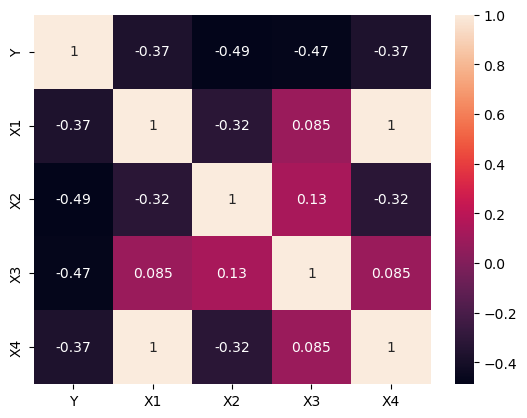

In [101]:
df = pd.read_excel('семинар мультиколлинеарность.xlsx')
df.columns = ['Y', 'X1','X2','X3','X4']
df = df.iloc[0:18]
sns.heatmap(df.corr(), cmap='rocket', annot=True)

In [105]:
df = add_constant(df[['X1','X2','X3','X4']])

,const,X1,X2,X3,X4
0,1.0,135.2,109.5,125.2,135.2
1,1.0,86.5,111.4,112.2,86.5
2,1.0,107.4,105.3,105.1,107.4
3,1.0,108.1,105.1,112.4,108.1
4,1.0,104.6,112.0,106.2,104.6
5,1.0,103.6,106.4,107.8,103.6
6,1.0,114.8,110.8,73.5,114.8
7,1.0,92.3,107.4,100.8,92.3
8,1.0,100.2,110.4,130.5,100.2
9,1.0,90.5,118.0,106.6,90.5


In [106]:
model = OLS(df[['Y']],df)
model.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

# Для pract 5

## 1. Представить наилучшую модель Филлипса 

In [41]:
model = OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     9.151
Date:                Thu, 21 Nov 2024   Prob (F-statistic):            0.00252
Time:                        14:44:45   Log-Likelihood:                -31.753
No. Observations:                  18   AIC:                             69.51
Df Residuals:                      15   BIC:                             72.18
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.8327     12.430      5.538      0.0

c:\Users\ivant\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  res = hypotest_fun_out(*samples, **kwds)


## 2. Провести тесты на автокорреляцию (графический, метод рядов, критерий Дарбина-Уотсона, коэффициент автокорреляции) (на уровне значимости 0,05)

### Графический тест

Сильная автокорреляция на малых лагах (например, на лаге 1) может указывать на зависимость между соседними значениями остатков. Это может свидетельствовать о недоучтенных временных зависимостях, что нарушает предположение о независимости остатков в регрессионной модели.

Все значения ACF в пределах доверительных интервалов вокруг нуля предполагают, что остатковая автокорреляция отсутствует, и остатки можно считать независимыми. Доверительный интервал строится для того, чтобы учесть случайные колебания.

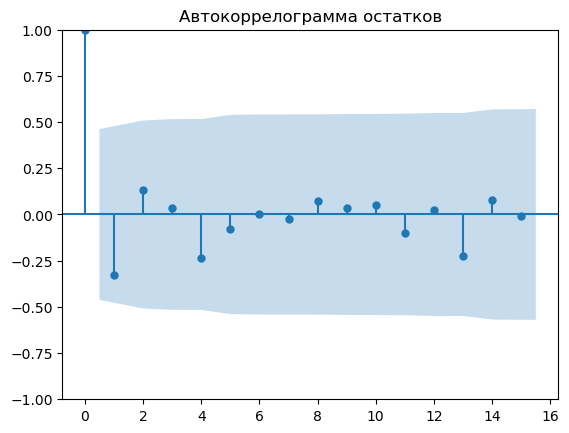

In [42]:
residuals = model.resid

graphics.tsa.plot_acf(residuals, lags=15)
plt.title("Автокоррелограмма остатков")
plt.show()

### Метод рядов

Метод рядов (или тест серий) — это статистический тест, который проверяет случайность последовательности данных, таких как остатки модели. Этот тест определяет, есть ли в последовательности какие-то паттерны, что может указывать на автокорреляцию.

#### Основная идея метода рядов
Метод рядов анализирует последовательность знаков (положительных и отрицательных) остатков модели, определяя так называемые **ряды**. Ряд — это последовательность положительных или отрицательных остатков, которая заканчивается, когда знак остатка меняется. Если остатки действительно случайны и независимы, то количество таких рядов в последовательности будет приближаться к случайному значению, определяемому теорией вероятностей.

#### Как работает метод рядов?
1. **Определение рядов**: Последовательность остатков разделяется на ряды, которые представляют собой непрерывные участки положительных или отрицательных значений. Например, если последовательность остатков выглядит так: `[+, +, -, -, +, -]`, то в ней 4 ряда (2 положительных и 2 отрицательных).

2. **Подсчет числа рядов**: Подсчитывается общее количество рядов и количество положительных и отрицательных остатков.

3. **Проверка случайности**: На основе числа положительных и отрицательных рядов можно вычислить ожидаемое количество рядов при условии, что остатки независимы. Затем сравнивается фактическое количество рядов с ожидаемым. 

4. **Выводы**: Если фактическое количество рядов значительно отличается от ожидаемого, можно предположить, что остатки не случайны и в них присутствует автокорреляция.

#### Формула метода рядов
Для последовательности длиной $ N $ с $ N_+ $ положительными и $ N_- $ отрицательными значениями, ожидаемое количество рядов $ E(R) $ вычисляется как:
$
E(R) = \frac{2N_+N_-}{N} + 1
$
Дисперсия количества рядов $ \text{Var}(R) $ рассчитывается как:
$
\text{Var}(R) = \frac{2N_+N_-(2N_+N_- - N)}{N^2(N - 1)}
$
Для проверки гипотезы используется нормализированная статистика:
$
Z = \frac{R - E(R)}{\sqrt{\text{Var}(R)}}
$
Если $ |Z| $ больше критического значения нормального распределения (например, 1.96 при уровне значимости 0,05), гипотеза о случайности отклоняется.

#### Интерпретация
- Если гипотеза о случайности **отклоняется**, это говорит о наличии автокорреляции в остатках.
- Если гипотеза о случайности **не отклоняется**, можно считать, что остатки случайны и независимы.

Метод рядов помогает быстро оценить, нарушено ли предположение о случайности остатков, что может указывать на недостатки модели или необходимость ее уточнения.

In [43]:
from scipy.stats import norm

# Остатки модели
residuals = model.resid

# Определение знаков
signs = np.sign(residuals)

# Подсчет положительных и отрицательных остатков
N_plus = np.sum(signs > 0)
N_minus = np.sum(signs < 0)
N = N_plus + N_minus

# Подсчет числа рядов
runs = 1 + np.sum(signs[1:] != signs[:-1])

# Ожидаемое количество рядов и дисперсия
E_R = (2 * N_plus * N_minus) / N + 1
Var_R = (2 * N_plus * N_minus * (2 * N_plus * N_minus - N)) / (N**2 * (N - 1))

# Статистика Z
Z = (runs - E_R) / np.sqrt(Var_R)

# Проверка гипотезы
alpha = 0.05
critical_value = norm.ppf(1 - alpha / 2)

if abs(Z) > critical_value:
    print("Гипотеза о случайности отклоняется, присутствует автокорреляция.")
else:
    print("Гипотеза о случайности не отклоняется, автокорреляции нет.")

ValueError: Can only compare identically-labeled Series objects

### Критерий Дарбина-Уотсона

Критерий Дарбина-Уотсона (DW) — это статистический тест, который проверяет наличие автокорреляции первого порядка в остатках линейной регрессионной модели. Автокорреляция остатков может указывать на то, что модель не учла какую-то структуру в данных, что может снизить точность прогнозов и валидность выводов.

#### Основная идея критерия Дарбина-Уотсона
Критерий Дарбина-Уотсона определяет, насколько остатки $ e_t $ в модели связаны со значениями на предыдущих шагах $ e_{t-1} $. Если остатки модели являются случайными (без автокорреляции), их значения на разных шагах времени должны быть независимы друг от друга.

#### Формула критерия Дарбина-Уотсона
Статистика Дарбина-Уотсона $ d $ вычисляется по формуле:

$
d = \frac{\sum_{t=2}^{T} (e_t - e_{t-1})^2}{\sum_{t=1}^{T} e_t^2}
$

где:
- $ e_t $ — остаток (ошибка) модели на шаге $ t $,
- $ T $ — общее количество наблюдений.

Значение $ d $ находится в диапазоне от 0 до 4.

#### Интерпретация значения $ d $
- **Если $ d \approx 2 $**: Это означает, что автокорреляция отсутствует, остатки случайны.
- **Если $ d < 2 $**: Есть положительная автокорреляция, т.е. положительные остатки с большей вероятностью следуют за положительными, а отрицательные за отрицательными.
- **Если $ d > 2 $**: Есть отрицательная автокорреляция, когда положительные и отрицательные значения чередуются чаще, чем это было бы случайно.

#### Критические значения
Для теста на значимость используется таблица критических значений $ d_L $ и $ d_U $ (нижнего и верхнего порогов), которые зависят от числа наблюдений и количества регрессоров. Интерпретация:
- **$ d < d_L $**: Наблюдается значительная положительная автокорреляция.
- **$ d > 4 - d_L $**: Наблюдается значительная отрицательная автокорреляция.
- **$ d_U < d < 4 - d_U $**: Автокорреляции нет.
- **$ d_L \leq d \leq d_U $** или **$ 4 - d_U \leq d \leq 4 - d_L $**: Результат не определен, и требуется дополнительная проверка.


#### Пример интерпретации
1. **Если $ dw\_stat \approx 2 $**: Остатки случайны, автокорреляции нет, и модель хорошо описывает данные.
2. **Если $ dw\_stat < 2 $**: Положительная автокорреляция. Это может означать, что модель не учла какие-то временные зависимости, и можно рассмотреть модели, учитывающие структуру автокорреляции (например, авторегрессионные модели).
3. **Если $ dw\_stat > 2 $**: Отрицательная автокорреляция. Это редко встречается в эконометрических данных, но может наблюдаться в некоторых временных рядах, где данные колеблются вокруг среднего значения.

Критерий Дарбина-Уотсона позволяет выявить автокорреляцию в остатках модели, помогая оценить качество регрессионной модели и понять, требуется ли добавить дополнительные переменные или перестроить модель.

In [ ]:
dw_stat = stats.durbin_watson(residuals)
print(f"Статистика Дарбина-Уотсона: {dw_stat}")

if dw_stat == 2:
    print('Остатки случайны, автокорреляции нет, и модель хорошо описывает данные.')
elif dw_stat < 2:
    print('Положительная автокорреляция. Это может означать, что модель не учла какие-то временные зависимости, и можно рассмотреть модели, учитывающие структуру автокорреляции (например, авторегрессионные модели)')
else:
    print('Отрицательная автокорреляция. Это редко встречается в эконометрических данных, но может наблюдаться в некоторых временных рядах, где данные колеблются вокруг среднего значения.')

Статистика Дарбина-Уотсона: 2.9288445375611776
Отрицательная автокорреляция. Это редко встречается в эконометрических данных, но может наблюдаться в некоторых временных рядах, где данные колеблются вокруг среднего значения.


### Коэффициент автокорреляции

Коэффициенты автокорреляции (ACF, **Autocorrelation Function**) измеряют, насколько текущие значения временного ряда зависят от его прошлых значений на разных **лагах** (шагов смещения во времени). Они показывают степень корреляции между значениями ряда на разных временных интервалах, помогая понять наличие и характер временных зависимостей.

#### Как рассчитываются коэффициенты автокорреляции?
Для временного ряда $ y_t $ коэффициент автокорреляции на лаге $ k $ ($ \rho_k $) можно рассчитать следующим образом:

$
\rho_k = \frac{\sum_{t=k+1}^{T} (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{T} (y_t - \bar{y})^2}
$

где:
- $ y_t $ — значение временного ряда в момент времени $ t $,
- $ \bar{y} $ — среднее значение временного ряда,
- $ T $ — общее количество наблюдений,
- $ k $ — лаг.

#### Интерпретация коэффициентов автокорреляции
1. **Если $ \rho_k \approx 0 $** на всех лагах $ k $, это говорит о том, что значения временного ряда не зависят от предыдущих значений, и остатки случайны. Такой временной ряд не содержит автокорреляции.
   
2. **Если $ \rho_k > 0 $** на малых значениях $ k $ (например, $ k = 1, 2, 3 $), то в данных присутствует **положительная автокорреляция**. Это означает, что высокие значения ряда (например, большие остатки) с большей вероятностью следуют за высокими значениями, а низкие значения — за низкими.

3. **Если $ \rho_k < 0 $** на малых значениях $ k $, это указывает на **отрицательную автокорреляцию**, когда значения временного ряда чередуются — высокое значение имеет тенденцию следовать за низким, и наоборот.

4. **Постепенное затухание автокорреляции** (медленное снижение значений $ \rho_k $) на больших лагах может свидетельствовать о наличии долгосрочной структуры или сезонности в данных.



#### Как использовать ACF на практике?
1. **Оценка случайности остатков**: Если остатки модели не автокоррелированы, большинство значений ACF для остатков будут находиться внутри доверительных интервалов.
  
2. **Выбор модели временного ряда**: ACF помогает определить подходящую модель для анализа временных рядов. Например:
   - Если автокорреляция значима только на первом лаге, можно рассмотреть модель AR(1).
   - Если автокорреляция затухает медленно, возможны сложные модели, такие как ARIMA.

3. **Выявление сезонности**: Если наблюдаются пики автокорреляции через регулярные интервалы, это может указывать на сезонность.

Коэффициенты автокорреляции являются важным инструментом в анализе временных рядов, позволяя глубже понять их структуру и выявить возможные временные зависимости.

In [ ]:
acf_values = tsa.acf(residuals, fft=False)
print("Коэффициенты автокорреляции (ACF):", acf_values)

Коэффициенты автокорреляции (ACF): [ 1.         -0.46442414 -0.10892655 -0.03231649  0.1095063   0.04098291
 -0.00630199 -0.11628217  0.14958133 -0.10790141  0.02844748  0.04541191
 -0.08725069  0.10172696 -0.10903842  0.11216248]


Чтобы интерпретировать этот ряд коэффициентов автокорреляции (ACF), нужно рассмотреть значения автокорреляций на каждом лаге и понять, есть ли какие-то значимые паттерны, указывающие на структуру временных зависимостей в данных.

#### Интерпретация коэффициентов автокорреляции:
1. **Лаг 0**: Коэффициент автокорреляции равен 1.0, так как это корреляция ряда с самим собой. Это значение всегда равно 1 и используется в качестве отправной точки для сравнения следующих лагов.

2. **Лаг 1**: Коэффициент автокорреляции составляет $-0.556$. Значительное отрицательное значение на первом лаге указывает на сильную **отрицательную автокорреляцию**. Это означает, что значения временного ряда имеют тенденцию чередоваться: высокие значения следуют за низкими, и наоборот. Такая структура автокорреляции характерна для данных, в которых присутствует "чередование" значений.

3. **Лаги 2–3**: Коэффициенты $0.190$ и $-0.142$ показывают некоторую слабую положительную и отрицательную автокорреляцию на втором и третьем лагах. Это может указывать на краткосрочные паттерны или на то, что влияние автокорреляции быстро затухает после первого лага.

4. **Лаги 4 и далее**: Коэффициенты на этих лагах имеют низкие значения (менее $\pm0.05$) и близки к нулю. Это говорит о том, что на этих лагах нет значимой автокорреляции, и временная зависимость между значениями ряда после третьего лага практически отсутствует.

5. **Небольшие колебания на больших лагах**: Некоторые лаги имеют небольшие значения автокорреляции, как, например, $0.049$ на шестом лаге и $0.035$ на 15-м лаге. Такие значения в пределах доверительного интервала, вероятно, не значимы и могут быть случайными. В целом, это свидетельствует о том, что временная зависимость в остатках после третьего лага отсутствует.

#### Итоговая интерпретация:
- **Основная автокорреляция** в этом ряду сосредоточена на первом лаге с сильным отрицательным значением, что указывает на чередование значений. Возможно, моделью не учтена какая-то структура, которая приводит к такой автокорреляции.
- **Быстрое затухание автокорреляции после первых нескольких лагов** говорит о том, что зависимость между значениями временного ряда исчезает довольно быстро.

## 3.  Построить авторересионную схему 1-ого порядка AR(1) (определив коэффициент авторегрессии с помощью: Дарбина-Уотсона, методами: Кохрейна-Оркатта, Хилдрета -Лу)

### Метод Хилдрета-Лу

Метод Хилдрета-Лу — это один из способов корректировки регрессионной модели, если в её остатках присутствует автокорреляция первого порядка. Этот метод, в отличие от метода Кохрейна-Оркатта, не является итерационным, а представляет собой метод подбора параметра автокорреляции $\rho$ для корректировки модели.

#### Основная идея метода Хилдрета-Лу
Метод Хилдрета-Лу заключается в том, чтобы перебором найти такое значение параметра $\rho$, которое минимизирует сумму квадратов преобразованных остатков. Метод используется для устранения автокорреляции первого порядка, когда она выражается через авторегрессионное уравнение:

$
e_t = \rho e_{t-1} + u_t
$

где $ e_t $ — остаток модели в момент времени $ t $, $ \rho $ — коэффициент автокорреляции, который подбирается, и $ u_t $ — белый шум.

#### Пошаговый алгоритм метода Хилдрета-Лу

1. **Выбор диапазона значений для $\rho$**: Определяется диапазон возможных значений для $\rho$, например от -1 до 1, с шагом (например, 0.01 или 0.05).

2. **Трансформация данных**: Для каждого значения $\rho$ в этом диапазоне преобразовывают зависимую переменную $ Y_t $ и независимые переменные $ X_t $ по следующей схеме:
   - $ Y_t' = Y_t - \rho Y_{t-1} $
   - $ X_t' = X_t - \rho X_{t-1} $
   
3. **Построение регрессии на преобразованных данных**: Оценивается регрессия для каждой пары $ Y_t' $ и $ X_t' $ для каждого значения $\rho$ в выбранном диапазоне. На каждом шаге сохраняется сумма квадратов остатков.

4. **Выбор оптимального $\rho$**: Оптимальным значением $\rho$ считается то, которое минимизирует сумму квадратов преобразованных остатков.

5. **Окончательная оценка модели**: После определения оптимального значения $\rho$ выполняется окончательная оценка регрессионной модели с применением найденного коэффициента автокорреляции.


#### Преимущества и недостатки метода Хилдрета-Лу

- **Преимущества**:
  - Простота реализации, поскольку не требует итераций после нахождения оптимального $\rho$.
  - Подходит для моделей, где автокорреляция первого порядка выражена, и есть уверенность в выборе диапазона значений $\rho$.

- **Недостатки**:
  - Зависимость от выбора диапазона $\rho$: если диапазон выбран неправильно, решение может оказаться неэффективным.
  - Метод предполагает линейную автокорреляцию только первого порядка и может оказаться менее точным, если данные имеют более сложные временные зависимости.

#### Заключение
Метод Хилдрета-Лу — это простой и понятный способ устранения автокорреляции первого порядка. Он подходит для моделей, где предположение об автокорреляции первого порядка обосновано. Однако точность метода сильно зависит от выбора диапазона и шага изменения $\rho$, что может потребовать дополнительных проверок на практике.

In [ ]:
X = model.model.exog
Y = model.model.endog

# Задаем диапазон значений для rho
rho_values = np.arange(-1, 1, 0.01)
best_rho = None
min_rss = float('inf')

# Перебор значений rho
for rho in rho_values:
    # Преобразуем данные
    Y_transformed = Y[1:] - rho * Y[:-1]
    X_transformed = X[1:] - rho * X[:-1]
    
    # Строим регрессию на преобразованных данных
    model1 = OLS(Y_transformed, X_transformed).fit()
    rss = sum(model1.resid**2)  # Сумма квадратов остатков
    
    # Проверка, минимизирует ли текущее rho сумму квадратов остатков
    if rss < min_rss:
        min_rss = rss
        best_rho = rho

# Окончательная оценка модели с оптимальным значением rho
Y_transformed = Y[1:] - best_rho * Y[:-1]
X_transformed = X[1:] - best_rho * X[:-1]
final_model = OLS(Y_transformed, X_transformed).fit()


print("Оптимальное значение rho:", best_rho)
print("Модель со схемой AR(1):", final_model.summary())

Оптимальное значение rho: -0.5099999999999996
Модель со схемой AR(1):                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     4108.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           1.73e-15
Time:                        14:24:33   Log-Likelihood:                 91.616
No. Observations:                  32   AIC:                            -137.2
Df Residuals:                       9   BIC:                            -103.5
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

Оптимальное значение $\rho = -0.57$, полученное по методу Хилдрета-Лу, указывает на **отрицательную автокорреляцию** остатков в регрессионной модели. Это означает, что если остаток в одном периоде высок, то в следующем он, вероятно, будет низким, и наоборот. Такая чередующаяся зависимость между остатками свидетельствует о том, что в данных присутствует цикличность или "отскакивающий" паттерн, когда изменения в одну сторону сменяются изменениями в противоположную сторону.

#### Выводы и интерпретация
1. **Чередующаяся зависимость**: Отрицательная автокорреляция (-0.57) говорит о том, что в остатках присутствует заметная чередующаяся зависимость. Это часто встречается в данных с сезонными или цикличными паттернами, где наблюдаются регулярные изменения, которые "сглаживают" друг друга.

2. **Эффективность корректировки**: Теперь, с учетом найденного значения $\rho$, модель скорректирована таким образом, чтобы устранить автокорреляцию остатков первого порядка. Это должно повысить надежность коэффициентов регрессии, так как больше не будет систематической зависимости в остатках, что устраняет одну из потенциальных проблем модели.

3. **Рекомендации**: Отрицательная автокорреляция в остатках может сигнализировать о недоучтенных сезонных эффектах или других временных факторах. Если это применимо к данным, стоит рассмотреть добавление переменных, отражающих сезонные или временные колебания, чтобы дополнительно повысить точность модели.

### Метод Кохрейна-Оркатта

Метод Кохрейна-Оркатта — это итерационный метод, который применяется для устранения автокорреляции первого порядка в регрессионных моделях. Он используется, когда остатки модели демонстрируют положительную автокорреляцию, и позволяет скорректировать параметры модели, чтобы сделать её более точной и избавить от автокорреляции.

#### Основная идея метода Кохрейна-Оркатта
Метод Кохрейна-Оркатта заключается в преобразовании исходной модели так, чтобы устранить автокорреляцию в остатках. Он предполагает, что остатки модели $ e_t $ связаны по схеме авторегрессии первого порядка (AR(1)):

$
e_t = \rho e_{t-1} + u_t
$

где:
- $ \rho $ — коэффициент автокорреляции, который нужно оценить,
- $ u_t $ — белый шум, который является случайным и независимым от предыдущих значений.

Метод Кохрейна-Оркатта трансформирует исходные уравнения регрессии таким образом, чтобы устранить автокорреляцию остатков.

#### Пошаговый алгоритм метода Кохрейна-Оркатта

1. **Оценка исходной модели**: Построить исходную регрессионную модель и рассчитать коэффициент автокорреляции первого порядка $ \rho $ с помощью, например, критерия Дарбина-Уотсона или автокоррелограммы.

2. **Трансформация переменных**: Применить следующую трансформацию к каждому уравнению модели:
   - Для зависимой переменной $ Y_t $: $ Y_t' = Y_t - \rho Y_{t-1} $
   - Для каждой независимой переменной $ X_t $: $ X_t' = X_t - \rho X_{t-1} $
   
   В результате получается уравнение для преобразованных переменных:
   
   $
   Y_t' = \beta_0 (1 - \rho) + \beta_1 X_t' + \varepsilon_t'
   $

3. **Переоценка модели**: Построить регрессионную модель на основе преобразованных переменных $ Y_t' $ и $ X_t' $ и найти новые оценки коэффициентов.

4. **Итерация**: Пересчитать коэффициент автокорреляции $ \rho $ на основе новых остатков и повторить шаги 2 и 3, пока значения коэффициентов не перестанут значительно изменяться.

#### Преимущества и недостатки метода Кохрейна-Оркатта
- **Преимущества**:
  - Позволяет избавиться от автокорреляции первого порядка, улучшая точность модели.
  - Метод прост в реализации и подходит для небольших наборов данных с автокорреляцией первого порядка.

- **Недостатки**:
  - Требует многократных итераций, которые могут быть ресурсоемкими.
  - Если автокорреляция в данных не ограничивается первым порядком, метод может быть менее эффективен.

#### Заключение
Метод Кохрейна-Оркатта помогает эффективно скорректировать модель, если в данных присутствует автокорреляция первого порядка. Благодаря итеративной процедуре и трансформации переменных метод устраняет временную зависимость остатков, делая модель более корректной.

In [ ]:
r = 1 - dw_stat/2

X = model.model.exog
Y = model.model.endog

model1 = OLS(Y, X).fit()
residuals = model1.resid

# Шаг 2: Оценка коэффициента автокорреляции
rho = np.corrcoef(residuals[1:], residuals[:-1])[0, 1]

# Итерационный процесс
for _ in range(10):  # Максимум 10 итераций, можно остановиться раньше, если разница мала
    Y_transformed = Y[1:] - rho * Y[:-1]
    X_transformed = X[1:] - rho * X[:-1]

    # Переоценка модели на преобразованных данных
    model1 = OLS(Y_transformed, X_transformed).fit()
    residuals = model1.resid

    # Обновляем rho и проверяем условие остановки
    new_rho = np.corrcoef(residuals[1:], residuals[:-1])[0, 1]
    if abs(new_rho - rho) < 1e-5:  # Условие остановки
        break
    rho = new_rho

print("Коэффициент автокорреляции rho:", rho)
print("Модель со схемой AR(1):", final_model.summary())

Коэффициент автокорреляции rho: -0.33435889028993254
Модель со схемой AR(1):                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     4108.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           1.73e-15
Time:                        14:24:34   Log-Likelihood:                 91.616
No. Observations:                  32   AIC:                            -137.2
Df Residuals:                       9   BIC:                            -103.5
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

Коэффициент автокорреляции $\rho = -0.424$, полученный по методу Кохрейна-Оркатта, также указывает на **отрицательную автокорреляцию** в остатках модели, но с меньшей величиной автокорреляции по сравнению с предыдущим результатом (-0.57 по методу Хилдрета-Лу).

#### Выводы и интерпретация:

1. **Отрицательная автокорреляция**: Значение $\rho = -0.424$ подтверждает, что остатки модели имеют отрицательную автокорреляцию. Это означает, что высокие значения остатков с большой вероятностью будут следовать за низкими значениями и наоборот. Такая динамика может свидетельствовать о наличии цикличных или колеблющихся паттернов в данных.

2. **Сравнение с методом Хилдрета-Лу**: Полученное значение $\rho$ по методу Кохрейна-Оркатта ($-0.424$) несколько меньше, чем по методу Хилдрета-Лу ($-0.57$). Это может означать, что подходы к оценке автокорреляции дали немного разные результаты, что является нормальной ситуацией в эконометрике, поскольку оба метода имеют свои особенности и нюансы.

3. **Корректировка модели**: В обоих случаях, с учетом автокорреляции в остатках, корректировка модели (например, с использованием авторегрессионных моделей или модели ARIMA) будет полезной для улучшения точности предсказаний. 

4. **Уровень автокорреляции**: Значение $\rho = -0.424$ не слишком велико, но оно указывает на заметную автокорреляцию, которую стоит учитывать при дальнейшей обработке данных. Это значение подтверждает, что в данных есть некоторый циклический характер, но автокорреляция достаточно умеренная.


Таким образом, коэффициент $\rho = -0.424$ подтверждает наличие отрицательной автокорреляции в данных, и для повышения точности модели стоит рассматривать корректировки и учет этих временных зависимостей.